In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import ast
%matplotlib inline

In [2]:
mouse = 'FIAA45.6d'
lcm_directory = pathlib.Path(
   f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
)
# load datasets
barcodes_across_sample = pd.read_pickle(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/barcode_matrix_soma_thresholded.pkl"
)
ROI_3D = np.load(lcm_directory / "ROI_3D_10.npy")
sample_vol_and_regions =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]


In [3]:
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)

In [4]:
# ignore barcodes that are only found in one sample
barcodes_across_sample = barcodes_across_sample[
    barcodes_across_sample.astype(bool).sum(axis=1) > 1
]

In [54]:
if mouse == 'FIAA45.6a':
    cortical_samples = [
        3, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 
        22, 23, 27, 28, 29, 30, 31, 32, 33, 34, 39, 40, 41, 42, 43, 
        44, 45, 46, 47, 48, 49, 50, 54, 57, 58, 59, 60, 61, 62, 63, 
        64, 65, 66, 67, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 
        99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 
        114, 115, 116, 117, 118, 119, 120, 126, 127, 128, 129, 131, 
        132, 133, 134, 135, 136, 139, 144, 145, 146, 147, 148, 151, 
        152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 
        166, 167, 168, 169, 171, 172, 173, 174, 175, 176
    ]

In [5]:
if mouse == 'FIAA45.6d':
    cortical_samples = [
        4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
        25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 38, 39, 40, 41, 
        42, 43, 44, 45, 46, 51, 52, 53, 54, 55, 56, 57, 58, 59, 
        60, 61, 62, 63, 66, 70, 71, 72, 73, 74, 75, 76, 77, 78, 
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 93, 94, 95, 96, 
        97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 
        109, 110, 111, 112, 113, 117, 118, 119, 120, 121, 122, 
        123, 124, 125, 126, 127, 128, 132, 133, 134, 135, 136, 
        137, 138, 139, 140, 141, 142, 143, 147, 148, 149, 150, 
        151, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 
        164, 165, 167, 168, 169, 170, 172, 173, 174, 175, 177, 
        178, 179, 180, 181, 182, 183, 184, 185, 186
    ]

In [6]:
# remove any samples from 3D array that aren't cortical for flatmap visualisation
mask = np.isin(ROI_3D, cortical_samples)
ROI_3D[~mask] = 0

In [7]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)

In [8]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 168.62it/s]


In [9]:
# remove tubes in ROI flatmap that aren't in normalised barcode path
tubes = np.arange(
    np.min(barcodes_across_sample.columns), np.max(barcodes_across_sample.columns), 1
)
tubes_not_in = [i for i in tubes if i not in barcodes_across_sample.columns.to_list()]
for x in tubes_not_in:
    ROI_3D[ROI_3D == x] = 0

In [10]:
ROI_projection_max = proj_top.project_volume(ROI_3D)

Group subcortical regions

In [12]:
bg_atlas = BrainGlobeAtlas("allen_mouse_10um", check_latest=False)
thal_list = []
for index, r in sample_vol_and_regions.iterrows():
    if i != 'OB':
        for i in ast.literal_eval(r.regions):
            if i.startswith('Contra-'):
                i = i[len('Contra-'):]
            ancestors= bg_atlas.get_structure_ancestors(i)
            if 'TH'in ancestors:
                thal_list.append(r['ROI Number'])
                break

sub_cortical = {}
sub_cortical["IC"] = sample_vol_and_regions[sample_vol_and_regions['main']=='IC']['ROI Number'].to_list()
sub_cortical["SC"] = sample_vol_and_regions[(sample_vol_and_regions['main']=='SCm') | (sample_vol_and_regions['main']=='SCs')]['ROI Number'].to_list()
# sub_cortical['CLA'] = [20, 25, 9, 14]
sub_cortical["STR"] = sample_vol_and_regions[sample_vol_and_regions['main']=='STR']['ROI Number'].to_list()
sub_cortical["THAL"] = thal_list
sub_cortical["PONS"] = sample_vol_and_regions[sample_vol_and_regions['main']=='P']['ROI Number'].to_list()

In [13]:
#if you just want visual areas to look at
VIS_samples = sample_vol_and_regions[sample_vol_and_regions.main.str.contains('VIS')]['ROI Number'].to_list()
barcodes_across_sample =barcodes_across_sample[barcodes_across_sample[VIS_samples].ne(0).any(1)]

barcode_matrix = np.zeros(
    (len(barcodes_across_sample), max(barcodes_across_sample.columns.astype(int)) + 1)
)

for column in barcodes_across_sample:
    barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

# now set zero values to -1
barcode_matrix[:, 0] = -1

/tmp/ipykernel_107887/1690350036.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  barcodes_across_sample =barcodes_across_sample[barcodes_across_sample[VIS_samples].ne(0).any(1)]


In [14]:
# only look at subcortical regions that have passed qc
sub_cortical_updated = {}
for i in sub_cortical:
    sub_cortical_updated[i] = []
    for val in sub_cortical[i]:
        if int(val) in barcodes_across_sample.columns.to_list():
            sub_cortical_updated[i].append(int(val))

In [64]:
#do if you want to look at all projections

barcode_matrix = np.zeros(
    (len(barcodes_across_sample), max(barcodes_across_sample.columns.to_list()) + 1)
)

for column in barcodes_across_sample:
    barcode_matrix[:, column] = barcodes_across_sample[column].to_numpy()

# now set zero values to -1
barcode_matrix[:, 0] = -1

/tmp/ipykernel_107887/746627811.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_107887/746627811.py:19: RuntimeWarn

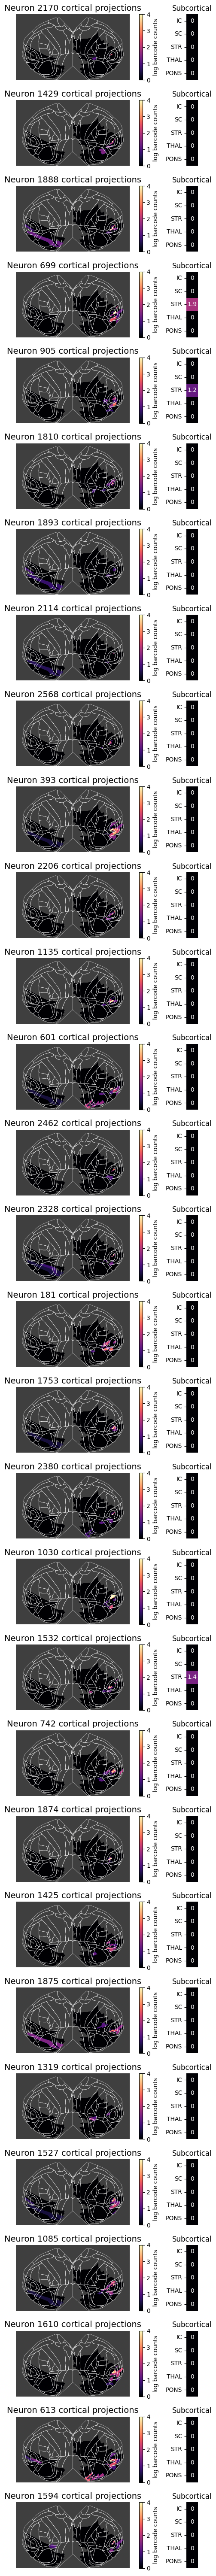

In [117]:
# Create the main figure and gridspec
vmax_val = 4
for iteration in range(1):
    fig = plt.figure(figsize=(7, 100))
    gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.1])
    cmap = plt.cm.get_cmap("magma").copy()
    # new_colours = cmap(np.linspace(0, 1, 30))
    # grey = ([0.3, 0.3, 0.3, 1])
    # new_colours[0, :] = grey
    # new_cmap = ListedColormap(new_colours)
    cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
    # Iterate over barcode_index values
    for i in range(30):
        # add a new subplot iteratively
        barcode_index = np.random.randint(len(barcode_matrix))
        #barcode_index = 511
        # Subplot - Main plot
        ax1 = fig.add_subplot(gs[i, 0])
        new_mat = np.log(
            1 + barcode_matrix[barcode_index, ROI_projection_max.astype(int)]
        ).T
        new_fig = ax1.imshow(new_mat, cmap=cmap, vmax =vmax_val)
        ax1.axis("off")
        cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
        cbar.set_label("log barcode counts")

        ax1.set_title(
            f"Neuron {barcode_index} cortical projections", fontdict={"fontsize": 14}
        )
        for k, boundary_coords in bf_left_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)
        for k, boundary_coords in bf_right_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)

        # Subplot - Seaborn heatmap
        sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
        for col in sub_cort_heat.columns:
            sub_cort_heat.loc[0, col] = np.log(
                barcode_matrix[barcode_index, sub_cortical_updated[col]].sum() + 1
            )
        ax2 = fig.add_subplot(gs[i, 1])
        sb.heatmap(
            sub_cort_heat.T,
            annot=True,
            cmap=cmap,
            cbar=False,
            cbar_ax=ax2,
            vmax=vmax_val)#new_mat.max(),
        
        ax2.set_title("Subcortical")
        ax2.set(xticklabels=[])
        # ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
        ax2.tick_params(left=True, bottom=False)

    plt.tight_layout()
    plt.show()

In [25]:
#centroids of 2D map
sample_matrix = ROI_projection_max.T

In [51]:
centroids = []
cortical_samples = np.array(cortical_samples)
cortical_samples = cortical_samples[np.isin(cortical_samples, np.unique(sample_matrix))]
for sample in cortical_samples:
    centroids.append(np.argwhere(ROI_projection_max == sample).mean(axis=0))
        
centroids = np.stack(centroids)
    

/camp/home/turnerb/.conda/envs/MAPseq_processing_py39/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 200. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(-0.5, 2351.5, 1359.5, -0.5)

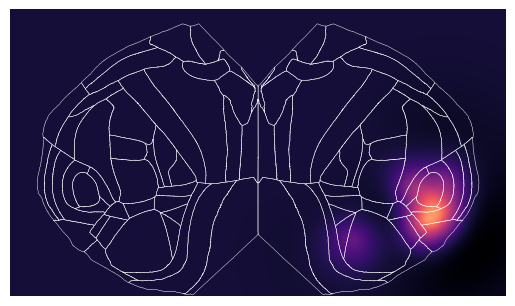

In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

kernel = WhiteKernel() + Matern(length_scale=10, length_scale_bounds=(50, 200))
y = barcode_matrix[1425, cortical_samples]
soma_idx = np.argmax(y)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=5).fit(
    np.delete(centroids, soma_idx, axis=0),
    np.delete(y, soma_idx)
)

ycoor, xcoor = np.mgrid[0:sample_matrix.shape[0], 0:sample_matrix.shape[1]]
X = np.concatenate((xcoor.reshape((-1, 1)), ycoor.reshape((-1, 1))), axis=1)
pred = gpr.predict(X)

plt.imshow(np.reshape(pred, sample_matrix.shape), cmap="magma", vmax=2)
for k, boundary_coords in bf_left_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, c="white", lw=0.3)
plt.axis("off")

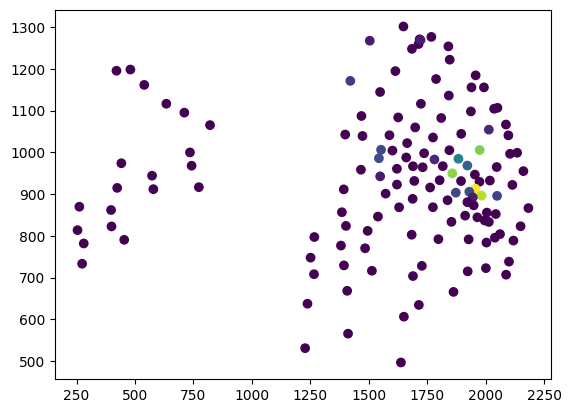

In [58]:
plt.scatter(centroids[:, 0], centroids[:, 1], c=barcode_matrix[511, cortical_samples], vmax=20)

In [ ]:
for tube in np.unique(ROI_3D_FIAA456a):
    if tube > 0:
        centroid = np.argwhere(ROI_3D_FIAA456a == tube).mean(axis=0)
        tubes_FIAA456a.append(tube)
        centroids_FIAA456a.append(centroid)

/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/806247477.py:18: RuntimeWarning: divide by zero encountered in log
  new_mat = np.log(
/tmp/ipykernel_80834/8062474

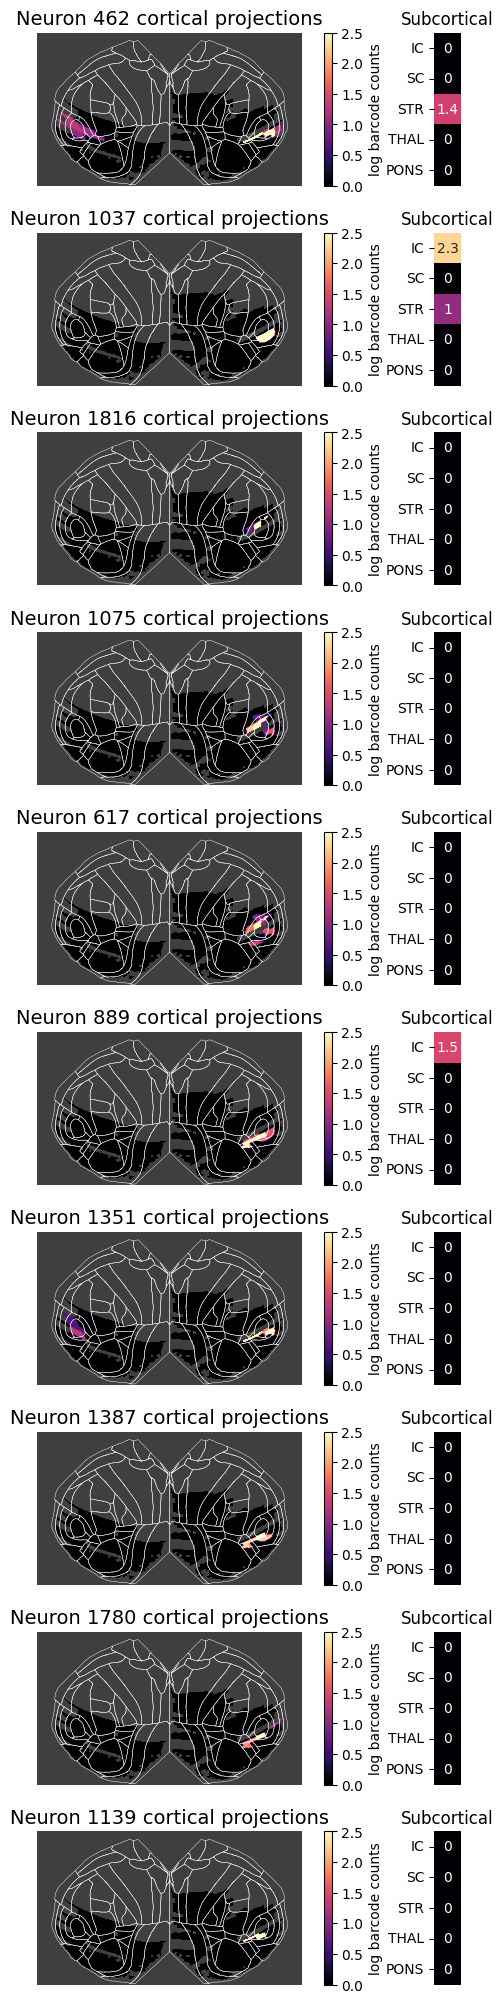

In [67]:
# Create the main figure and gridspec
vmax_val = 2.5
for iteration in range(1):
    fig = plt.figure(figsize=(7, 100))
    gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.1])
    cmap = plt.cm.get_cmap("magma").copy()
    # new_colours = cmap(np.linspace(0, 1, 30))
    # grey = ([0.3, 0.3, 0.3, 1])
    # new_colours[0, :] = grey
    # new_cmap = ListedColormap(new_colours)
    cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
    # Iterate over barcode_index values
    for i in range(10):
        # add a new subplot iteratively
        barcode_index = np.random.randint(len(barcode_matrix))
        # Subplot - Main plot
        ax1 = fig.add_subplot(gs[i, 0])
        new_mat = np.log(
            1 + barcode_matrix[barcode_index, ROI_projection_max.astype(int)]
        ).T
        new_fig = ax1.imshow(new_mat, cmap=cmap, vmax =vmax_val)
        ax1.axis("off")
        cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
        cbar.set_label("log barcode counts")

        ax1.set_title(
            f"Neuron {barcode_index} cortical projections", fontdict={"fontsize": 14}
        )
        for k, boundary_coords in bf_left_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)
        for k, boundary_coords in bf_right_boundaries.items():
            ax1.plot(*boundary_coords.T, c="white", lw=0.3)

        # Subplot - Seaborn heatmap
        sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
        for col in sub_cort_heat.columns:
            sub_cort_heat.loc[0, col] = np.log(
                barcode_matrix[barcode_index, sub_cortical_updated[col]].sum() + 1
            )
        ax2 = fig.add_subplot(gs[i, 1])
        sb.heatmap(
            sub_cort_heat.T,
            annot=True,
            cmap=cmap,
            cbar=False,
            cbar_ax=ax2,
            vmax=vmax_val)#new_mat.max(),
        
        ax2.set_title("Subcortical")
        ax2.set(xticklabels=[])
        # ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
        ax2.tick_params(left=True, bottom=False)

    plt.tight_layout()
    plt.show()

    # plt.savefig(convert_to_flat_path/f'example_projections/random_{iteration}.pdf')